In [1]:
import torch
import torch.nn as nn
import sys
sys.path.append('../../downscaling_module')
sys.path.append('../../')

from data.datasets import ConvLSTMDataset

In [2]:
from models.convlstm_commented import ConvLSTM
from data.transforms import transforms

In [42]:
from data_visualisation import plot_single

In [73]:
from icecream import ic

In [82]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the data
lr_data = torch.load('../../serialized_data/dataLR.pt')['data']  # Shape: (S, T, C, H_lr, W_lr)
hr_data = torch.load('../../serialized_data/dataHR.pt')['data']  # Shape: (S, T, C, H_hr, W_hr)

# Define the transform
transform = transforms

dataset = ConvLSTMDataset(lr_data, hr_data, transform=transform)

# Get a single sample
lr_sample, hr_sample = dataset[49]  # Shapes: (T, C, H, W)

# Add batch dimension
lr_sample = lr_sample.unsqueeze(0)  # Shape: (1, T, C, H, W)
hr_sample = hr_sample.unsqueeze(0)  # Shape: (1, T, C, H, W)

# lr_sample = lr_sample[:, :, 0, :, :]
# hr_sample = hr_sample[:, :, 0, :, :]

# lr_sample.unsqueeze_(2)
# hr_sample.unsqueeze_(2)

# Move tensors to device
lr_sample = lr_sample.to(device)
hr_sample = hr_sample.to(device)

print("Shapes of the sample:", lr_sample.shape, hr_sample.shape)

# Model parameters
input_dim = lr_sample.shape[2]    # Number of input channels C
# output_dim = hr_sample.shape[2]   # Number of output channels
hidden_dim = [2]             # Hidden dimensions for each layer
kernel_size = (3, 3)              # Kernel size for each layer
num_layers = 1  # Number of layers
num_epochs = 2000                  # Increase the number of epochs to ensure overfitting
learning_rate = 0.001

print("Input dimension:", input_dim, "Hidden dimensions:", hidden_dim, "Kernel size:", kernel_size, "Number of layers:", num_layers)

# Initialize the model
model = ConvLSTM(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    kernel_size=kernel_size,
    num_layers=num_layers,
    batch_first=True,
    bias=True,
    return_all_layers=True        
).to(device)

Transforming with cutSequence
Transforming with bilinearInterpolation
Before interpolation:
LR: torch.Size([14, 500, 2, 1, 50]) HR: torch.Size([14, 500, 2, 5, 250])
Reshaped LR: torch.Size([7000, 2, 1, 50])
HR: torch.Size([14, 500, 2, 5, 250])
After interpolation:
LR resized: torch.Size([14, 500, 2, 5, 250]) HR: torch.Size([14, 500, 2, 5, 250])
Transforming with min_max_scale
Shapes of the sample: torch.Size([1, 10, 2, 5, 250]) torch.Size([1, 10, 2, 5, 250])
Input dimension: 2 Hidden dimensions: [2] Kernel size: (3, 3) Number of layers: 1


/tmp/ipykernel_6337/1660752808.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lr_data = torch.load('../../serialized_data/dataLR.pt')['data']  # Shape: (S, T, C, H_lr, 

In [95]:
model.load_state_dict(torch.load('/home/maxime/DL-ML/downscalling/experimentations/convlstm_overfit_model.pth'))

/tmp/ipykernel_6337/2778521180.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/home/maxime/DL-ML/downscalling/experimentations/convlst

<All keys matched successfully>

In [96]:
# Set the model to train mode
model.train()

# Run the data through the model
out = model(lr_sample)[0][0].detach().cpu()

In [97]:
#compute MSE
criterion = nn.MSELoss()
loss = criterion(out, hr_sample.cpu())
print("MSE Loss:", loss.item())

MSE Loss: 0.00020297602168284357


In [106]:
out.shape, hr_sample.shape

(torch.Size([1, 10, 2, 5, 250]), torch.Size([1, 10, 2, 5, 250]))

In [107]:
out[0, 5].shape, hr_sample[0, 5].shape

(torch.Size([2, 5, 250]), torch.Size([2, 5, 250]))

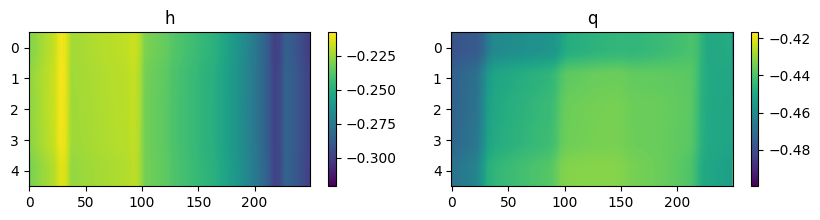

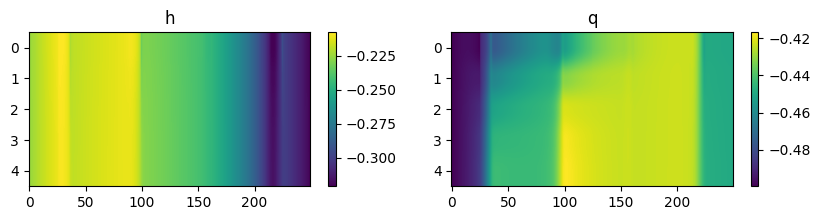

In [111]:
from data_visualisation import plot_two
plot_two(out[0,9], hr_sample[0, 9])

In [104]:
ic(torch.min(out[0,0]), torch.max(out[0,0]), torch.min(hr_sample[0,0]), torch.max(hr_sample[0,0]))

ic| torch.min(out[0,0]): tensor(-0.4548)
    torch.max(out[0,0]): tensor(-0.1600)
    torch.min(hr_sample[0,0]): tensor(-0.4924, device='cuda:0')
    torch.max(hr_sample[0,0]): tensor(-0.1995, device='cuda:0')


(tensor(-0.4548),
 tensor(-0.1600),
 tensor(-0.4924, device='cuda:0'),
 tensor(-0.1995, device='cuda:0'))